In [ ]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [3]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

pd.options.display.max_rows = 150

In [4]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


''

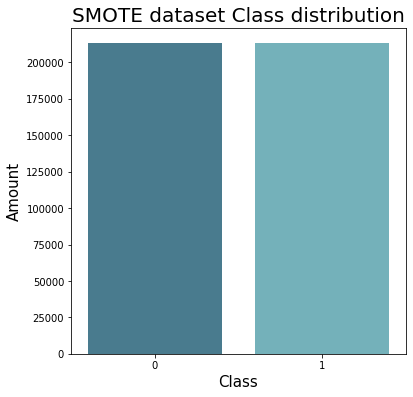

In [5]:
plt.figure(figsize = (6,6))
sns.barplot(x = [0,1], 
            y = pd.DataFrame(y_train_sm)[0].value_counts(),palette='GnBu_d')
plt.xlabel('Class', size = 15)
plt.ylabel('Amount', size = 15)
plt.title('SMOTE dataset Class distribution', size = 20)
;

In [7]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [8]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

In [9]:
def model_vis(model, index):
    prediction_train = model.predict(X_train)
    prediction_test = model.predict(X_test)
    
    cnf_train = confusion_matrix(y_train, prediction_train)
    cnf_test = confusion_matrix(y_test, prediction_test)
    
    recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
    recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])
    
    precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
    precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])
    
    roc_train = roc_auc_score(y_train, prediction_train)
    roc_test = roc_auc_score(y_test, prediction_test)

    result = {
        'false_positive_test' : cnf_test[0,1],
        'false_negative_test' : cnf_test[1,0],
        'recall_train' : recall_train, 
        'recall_test' : recall_test,
        'precision_train' : precision_train, 
        'precision_test' : precision_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
    }
    
    output = pd.DataFrame(result,index = [index])
    
    plot_train = plot_confusion_matrix(cnf_train,f'{index} train')
    plot_test = plot_confusion_matrix(cnf_test,f'{index} test')
    
    feature_chart = feature_importance(model)
    
    return output

# Baseline

In [10]:
gradboost = GradientBoostingClassifier(random_state=42)
model = gradboost.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default,896,13,0.97832,0.894309,0.127382,0.109344,0.983361,0.940852


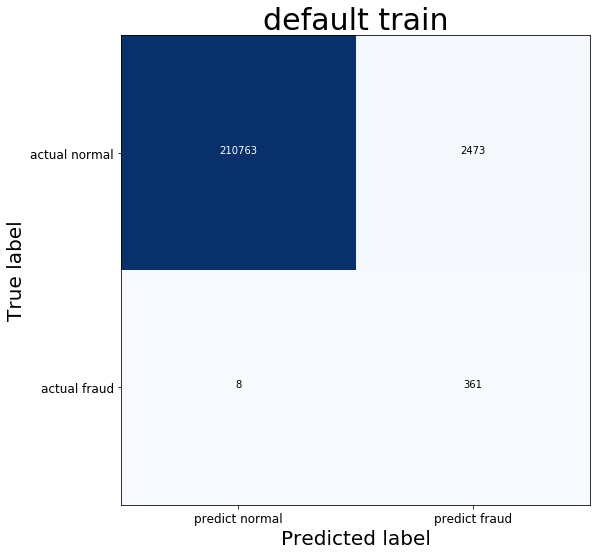

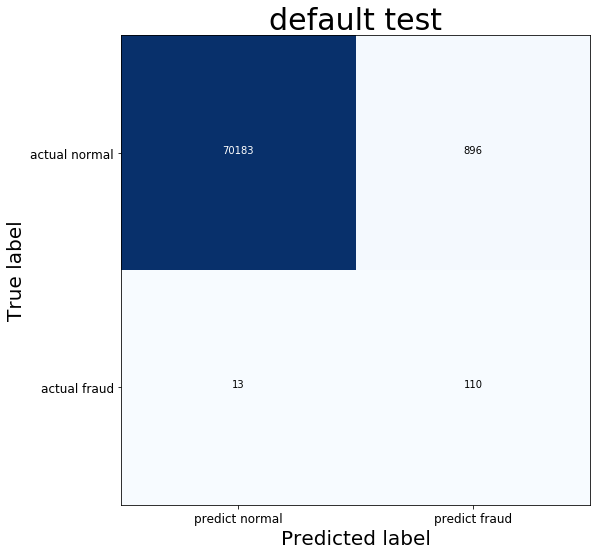

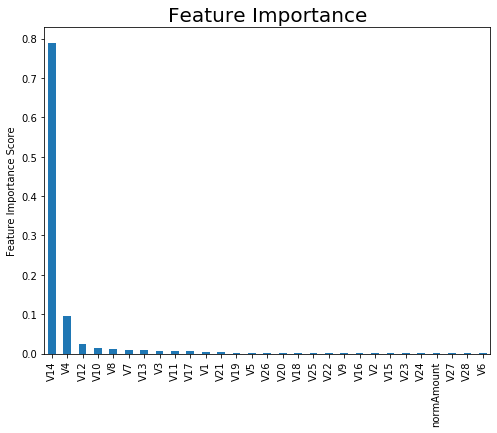

In [11]:
model_vis(model,'default')

# Gridsearch params

In [ ]:
# learning rate, n_estimator
# subsample
# max_depth
# min_samples_split, min_samples_leaf
# max_feature

## step 1: tuning loss, min_samples_split, main_samples_leaf

In [13]:
grid_param = {
    'loss' : ['deviance','exponential'],
    'min_samples_split': range(500,1001,100),
    'min_samples_leaf' : range(5,51,10),
}

gs1 = GridSearchCV(GradientBoostingClassifier(subsample = 0.8, 
                                             max_features='sqrt', 
                                             random_state=42), 
                  param_grid=grid_param,
                  n_jobs=4,
                  cv = 5,
                  verbose = 10)

In [14]:
gs1.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  6.8min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 21.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 26.6min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 30.4min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 35.4min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 39.2min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 46.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 53.3min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 60.3min
[Parallel(

In [15]:
gs1.best_params_,gs1.best_score_

({'loss': 'deviance', 'min_samples_leaf': 25, 'min_samples_split': 500},
 0.9773560766408922)

In [16]:
pd.DataFrame(gs1.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,77.613820,0.219205,0.160302,0.003716,deviance,25,500,"{'loss': 'deviance', 'min_samples_leaf': 25, '...",0.978111,0.975884,0.976610,0.977982,0.978193,0.977356,0.000937,1
18,74.540911,0.150992,0.178350,0.015451,deviance,35,500,"{'loss': 'deviance', 'min_samples_leaf': 35, '...",0.978416,0.975614,0.976610,0.977982,0.977619,0.977248,0.001012,2
0,76.741800,1.060795,0.173491,0.007567,deviance,5,500,"{'loss': 'deviance', 'min_samples_leaf': 5, 'm...",0.978053,0.975919,0.976610,0.976915,0.978158,0.977131,0.000859,3
24,78.021542,0.841850,0.175452,0.015952,deviance,45,500,"{'loss': 'deviance', 'min_samples_leaf': 45, '...",0.978428,0.975696,0.976645,0.976575,0.978193,0.977108,0.001040,4
6,78.955250,1.256985,0.179888,0.019463,deviance,15,500,"{'loss': 'deviance', 'min_samples_leaf': 15, '...",0.978053,0.975907,0.975965,0.976915,0.978193,0.977007,0.000980,5
25,80.464827,0.659361,0.202515,0.034835,deviance,45,600,"{'loss': 'deviance', 'min_samples_leaf': 45, '...",0.978498,0.975720,0.976247,0.977349,0.976868,0.976936,0.000956,6
1,78.322020,0.906392,0.250167,0.085759,deviance,5,600,"{'loss': 'deviance', 'min_samples_leaf': 5, 'm...",0.977549,0.975919,0.976071,0.976681,0.978158,0.976875,0.000860,7
19,75.017720,0.213695,0.170576,0.004780,deviance,35,600,"{'loss': 'deviance', 'min_samples_leaf': 35, '...",0.978498,0.975825,0.976247,0.976610,0.976868,0.976810,0.000914,8
13,79.077609,2.068845,0.193330,0.010289,deviance,25,600,"{'loss': 'deviance', 'min_samples_leaf': 25, '...",0.978100,0.975884,0.976247,0.976610,0.976868,0.976742,0.000756,9
27,114.979346,16.848208,0.258056,0.012768,deviance,45,800,"{'loss': 'deviance', 'min_samples_leaf': 45, '...",0.976939,0.975262,0.976247,0.977454,0.977736,0.976728,0.000891,10


# Gridsearch 1

In [18]:
gradboost_grid = GradientBoostingClassifier(loss = 'deviance',
                                            min_samples_leaf=25,
                                            min_samples_split=500,
                                            subsample= 0.8,
                                            max_features='sqrt',
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridseach 1,900,13,0.96477,0.894309,0.120067,0.108911,0.976267,0.940823


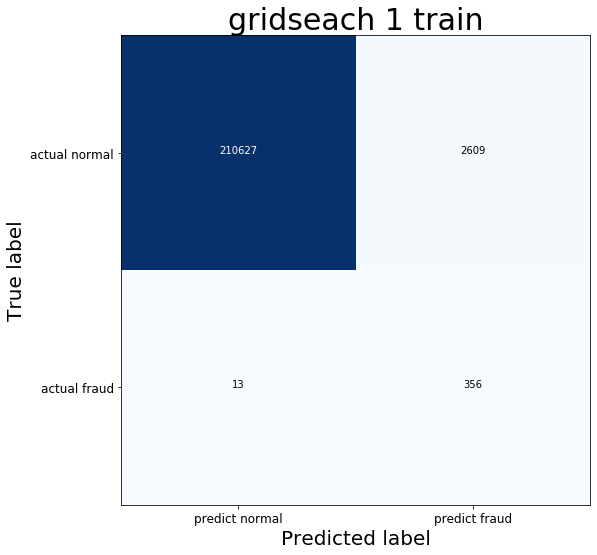

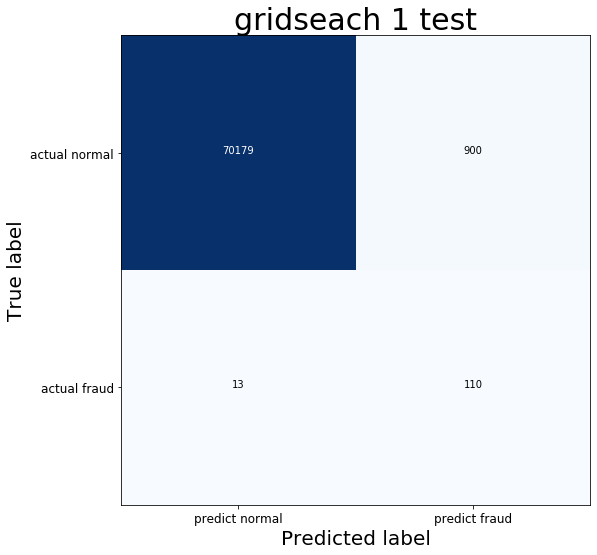

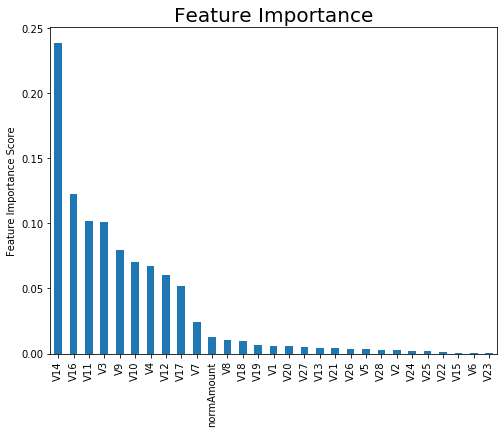

In [19]:
model_vis(model,'gridseach 1')

## step 2: continue minimize min_samples_split, min_samples_leaf

In [20]:
grid_param = {
    'min_samples_split': range(350,651,50),
    'min_samples_leaf' : range(20,31,2),
}

gs2 = GridSearchCV(GradientBoostingClassifier(subsample = 0.8, 
                                             max_features='sqrt', 
                                             random_state=42), 
                  param_grid=grid_param,
                  n_jobs=4,
                  cv = 5,
                  verbose = 10)

gs2.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 12.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 19.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 24.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 32.2min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 35.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 41.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 45.3min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 53.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 59.7min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 70.2min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 79.1min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 88.4min
[Parallel(

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
       

In [22]:
gs1.best_score_

0.9773560766408922

In [21]:
gs2.best_params_, gs2.best_score_

({'min_samples_leaf': 22, 'min_samples_split': 500}, 0.9774334560579673)

## Gridsearch 2 

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 2,900,13,0.96477,0.894309,0.120067,0.108911,0.976267,0.940823


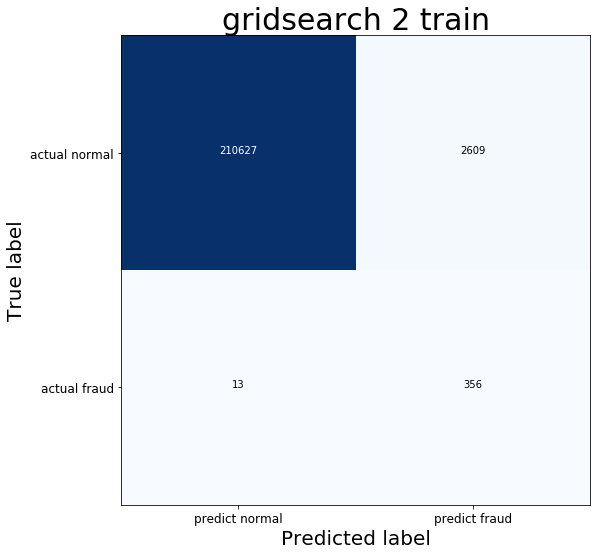

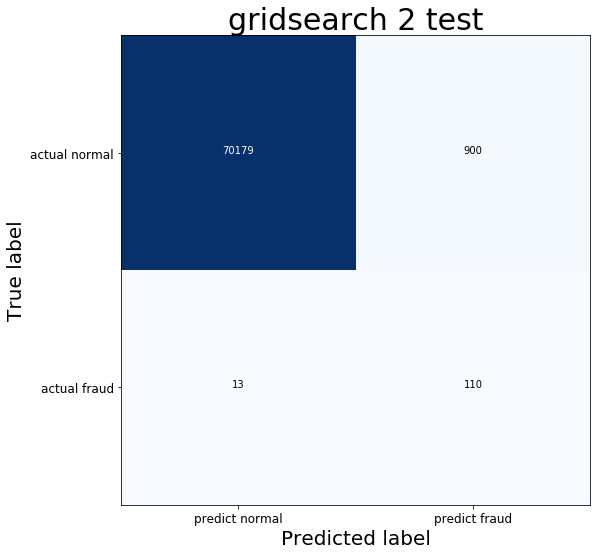

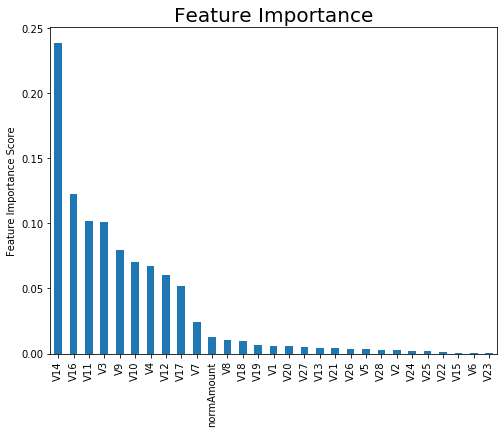

In [23]:
gradboost_grid = GradientBoostingClassifier(loss = 'deviance',
                                            min_samples_leaf=22,
                                            min_samples_split=500,
                                            subsample= 0.8,
                                            max_features='sqrt',
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

model_vis(model, 'gridsearch 2')

## Step 3: tune max_depth, subsample

In [28]:
# min_samples_leaf = 22, min_samples_split = 500, loss = 'deviance', max_features = 'sqrt'

grid_param = {
    'max_depth' : range(20,101,10),
#    'subsample' : np.arange(0.5,1.3,0.1)
}

gs3 = GridSearchCV(GradientBoostingClassifier(max_features='sqrt',
                                              min_samples_leaf=22,
                                              min_samples_split=500,
                                              loss='deviance',
                                              random_state=42),
                  param_grid=grid_param,
                  n_jobs=4,
                  cv = 5,
                  verbose = 10)

model_param = gs3.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 25.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 36.8min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 54.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 65.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 93.9min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed: 114.5min remaining:  5.3min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 120.6min finished


In [29]:
gs3.best_params_,gs3.best_score_

({'max_depth': 50}, 0.9998593109754979)

In [30]:
pd.DataFrame(gs3.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,556.620953,29.618020,1.014796,0.020050,50,{'max_depth': 50},0.999789,0.999859,0.999812,0.999906,0.999930,0.999859,0.000053,1
1,812.927955,167.977588,1.037405,0.022732,30,{'max_depth': 30},0.999801,0.999859,0.999848,0.999859,0.999918,0.999857,0.000037,2
0,699.710340,80.975683,1.401827,0.192389,20,{'max_depth': 20},0.999801,0.999824,0.999801,0.999871,0.999930,0.999845,0.000049,3
2,614.228346,13.256414,1.248725,0.119178,40,{'max_depth': 40},0.999777,0.999871,0.999801,0.999871,0.999906,0.999845,0.000048,4
4,535.621411,10.227478,1.022669,0.067374,60,{'max_depth': 60},0.999777,0.999848,0.999812,0.999848,0.999918,0.999841,0.000047,5
5,582.610222,26.315399,1.432822,0.676469,70,{'max_depth': 70},0.999777,0.999848,0.999812,0.999848,0.999918,0.999841,0.000047,5
6,627.147890,5.940901,1.094215,0.079423,80,{'max_depth': 80},0.999777,0.999848,0.999812,0.999848,0.999918,0.999841,0.000047,5
7,601.459921,10.111921,1.160476,0.192031,90,{'max_depth': 90},0.999777,0.999848,0.999812,0.999848,0.999918,0.999841,0.000047,5
8,521.668938,34.570794,0.919297,0.092740,100,{'max_depth': 100},0.999777,0.999848,0.999812,0.999848,0.999918,0.999841,0.000047,5


## Gridsearch 3

In [36]:
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=22, 
                                        min_samples_split=500, 
                                        loss = 'deviance', 
                                        max_features = 'sqrt', 
                                        max_depth=20, 
                                        subsample=1, 
                                        random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 3,19,22,1.0,0.821138,1.0,0.841667,1.0,0.910435


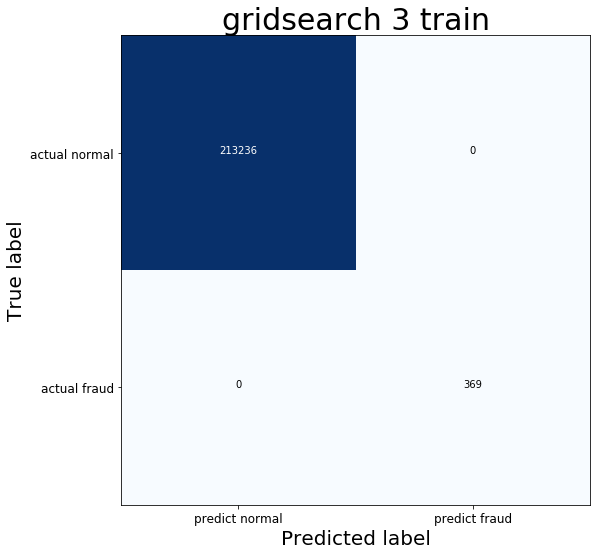

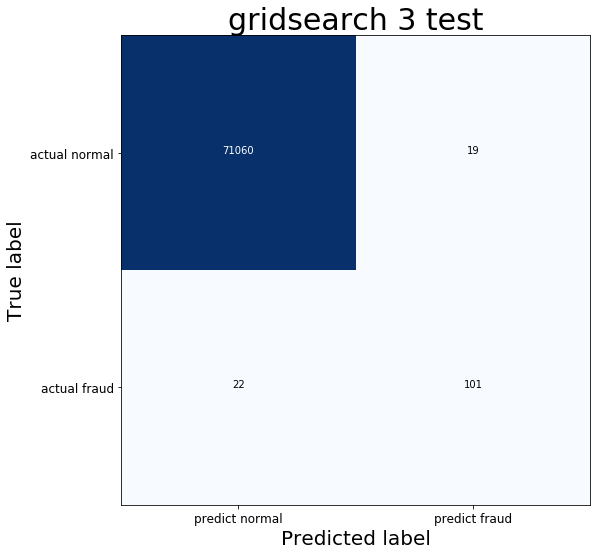

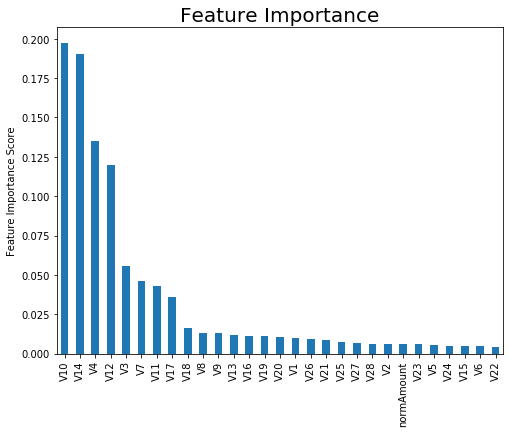

In [37]:
model_vis(model,'gridsearch 3')

In [38]:
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=22, 
                                        min_samples_split=500, 
                                        loss = 'deviance', 
                                        max_features = 'sqrt', 
                                        max_depth=50, 
                                        subsample=1, 
                                        random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 3,21,22,1.0,0.821138,1.0,0.827869,1.0,0.910421


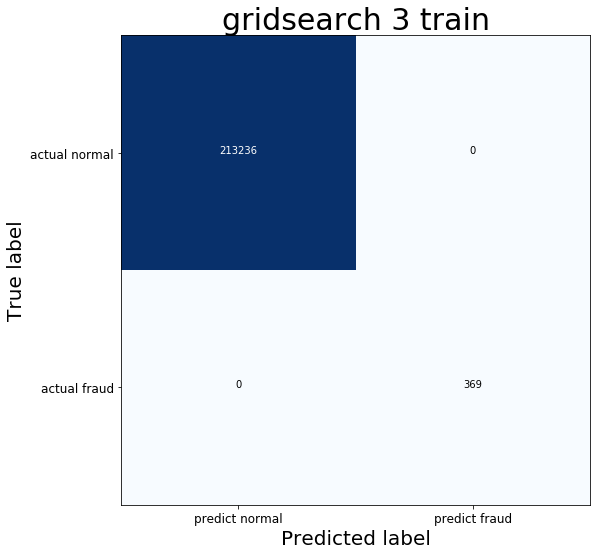

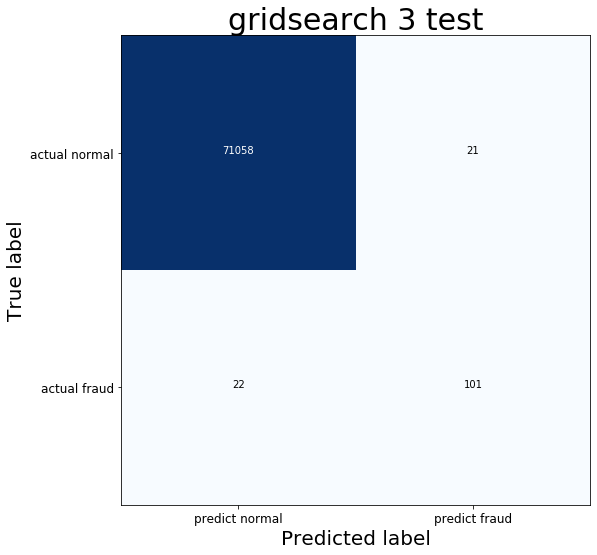

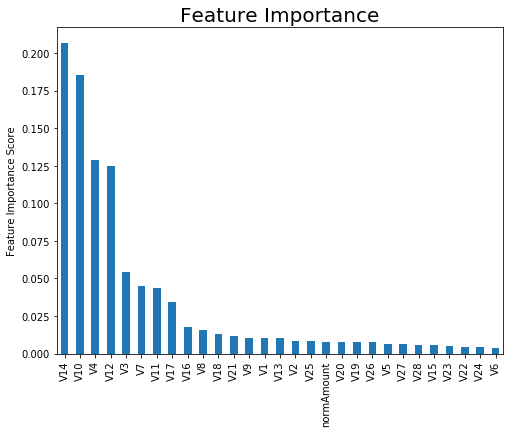

In [39]:
model_vis(model,'gridsearch 3')

## step 4: tuning n_estimators and learning_rate

In [40]:
grid_param = {
    'n_estimators': range(20,101,10),
    'learning_rate':[0.1,0.05,0.01]
}

gs4 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=22, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              max_depth=20, 
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs4.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 13.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 21.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 36.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 53.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 60.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 71.7min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 90.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 113.4min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 124.2min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 142.3min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed: 170.4min finished


In [41]:
gs4.best_params_, gs4.best_score_

({'learning_rate': 0.1, 'n_estimators': 100}, 0.9998405524663883)

In [42]:
pd.DataFrame(gs4.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,484.084658,3.252083,0.928224,0.023057,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.999766,0.999824,0.999789,0.999883,0.999941,0.999841,0.000064,1
7,439.875482,0.667135,0.870682,0.014630,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.999766,0.999812,0.999777,0.999859,0.999918,0.999826,0.000056,2
6,396.448412,2.425508,0.791744,0.012503,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.999766,0.999801,0.999777,0.999859,0.999918,0.999824,0.000057,3
5,348.436551,1.016444,0.710152,0.007727,0.1,70,"{'learning_rate': 0.1, 'n_estimators': 70}",0.999742,0.999789,0.999766,0.999812,0.999906,0.999803,0.000057,4
4,306.480085,6.090944,0.609651,0.011053,0.1,60,"{'learning_rate': 0.1, 'n_estimators': 60}",0.999719,0.999766,0.999719,0.999812,0.999836,0.999770,0.000048,5
17,517.559041,3.273599,1.045385,0.006337,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",0.999766,0.999707,0.999672,0.999754,0.999766,0.999733,0.000037,6
3,261.526928,9.624749,0.531385,0.029184,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.999719,0.999719,0.999695,0.999719,0.999801,0.999730,0.000036,7
16,463.202523,1.933412,0.925083,0.018077,0.05,90,"{'learning_rate': 0.05, 'n_estimators': 90}",0.999766,0.999707,0.999672,0.999719,0.999754,0.999723,0.000034,8
15,410.438476,1.093670,0.816747,0.010448,0.05,80,"{'learning_rate': 0.05, 'n_estimators': 80}",0.999730,0.999637,0.999660,0.999637,0.999754,0.999683,0.000049,9
14,359.129067,1.715219,0.732262,0.013213,0.05,70,"{'learning_rate': 0.05, 'n_estimators': 70}",0.999672,0.999625,0.999637,0.999601,0.999707,0.999648,0.000037,10


## Step 5: continue with learning_rate and n_estimators

In [49]:
grid_param = {
    'n_estimators': [50,100,300,500],
    'learning_rate':[0.05, 0.1, 0.3, 0.5]
}

gs5 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=22, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              max_depth=20, 
                                              subsample=1, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs5.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 20.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 50.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 64.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 83.6min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 101.7min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 111.3min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 118.8min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 127.2min finished


In [50]:
gs5.best_params_, gs5.best_score_

({'learning_rate': 0.1, 'n_estimators': 300}, 0.9998593109754979)

In [86]:
gs4.best_score_

0.9998639940390209

# gridsearch 5

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 5,19,23,1.0,0.813008,1.0,0.840336,1.0,0.90637


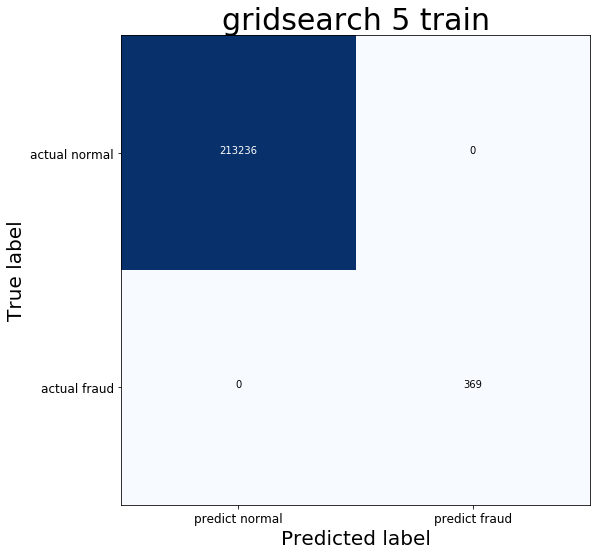

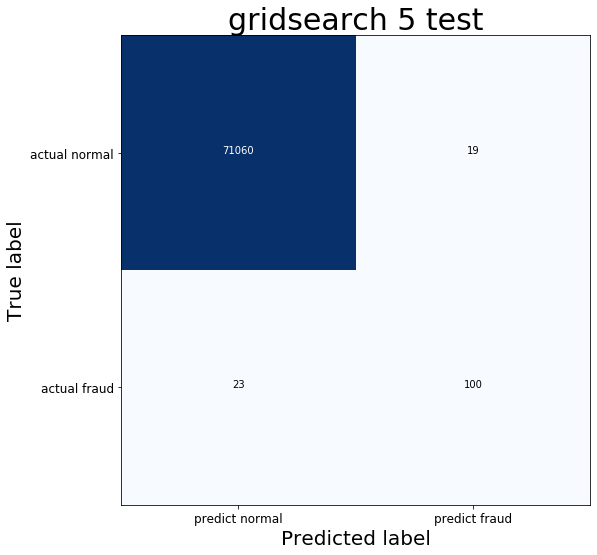

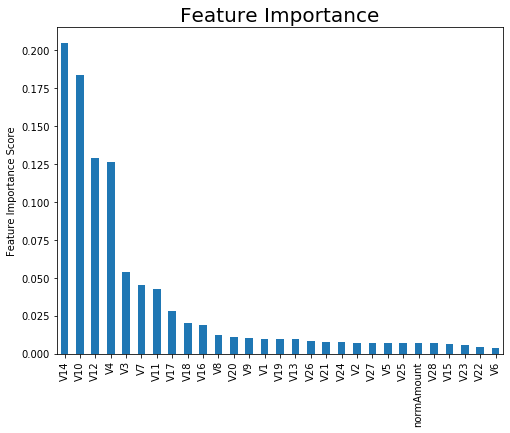

In [44]:
# n_estimator = 300
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=22, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=20, 
                                            subsample=1, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

model_vis(model,'gridsearch 5')

## step 6 tuning max_features

In [45]:
# total 29 features  (len(predictors))
grid_param = {
    'max_features': ['sqrt','auto','log2',8,9,10,11]
}

gs6 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=22, 
                                              min_samples_split=500, 
                                              loss = 'deviance',
                                              n_estimators=300,
                                              learning_rate=0.1,
                                              max_depth=20, 
                                              subsample=1, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs6.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 17.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 62.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 81.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 109.8min
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed: 142.2min remaining: 13.3min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 155.4min finished


In [46]:
gs6.best_params_,gs6.best_score_

({'max_features': 'log2'}, 0.9998686902987796)

In [51]:
pd.DataFrame(gs6.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,393.564837,2.530809,0.903893,0.007377,log2,{'max_features': 'log2'},0.999789,0.999859,0.999848,0.999906,0.999941,0.999869,0.000052,1
0,547.361574,30.129417,0.901623,0.022239,sqrt,{'max_features': 'sqrt'},0.999801,0.999848,0.999824,0.999883,0.999941,0.999859,0.000049,2
6,976.575173,41.131343,0.739611,0.068808,11,{'max_features': 11},0.999836,0.999848,0.999824,0.999859,0.999918,0.999857,0.000033,3
5,920.926438,5.572788,0.814258,0.004354,10,{'max_features': 10},0.999824,0.999812,0.999812,0.999894,0.999930,0.999855,0.000048,4
3,740.969038,4.719822,0.837460,0.006878,8,{'max_features': 8},0.999766,0.999836,0.999824,0.999883,0.999930,0.999848,0.000055,5
4,835.132135,8.363862,0.831661,0.016442,9,{'max_features': 9},0.999766,0.999824,0.999812,0.999883,0.999941,0.999845,0.000061,6
1,2760.630967,24.637872,0.785351,0.003270,auto,{'max_features': 'auto'},0.999801,0.999777,0.999789,0.999871,0.999918,0.999831,0.000054,7


## gridsearch 6

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
gridsearch 6,16,23,1.0,0.813008,1.0,0.862069,1.0,0.906392


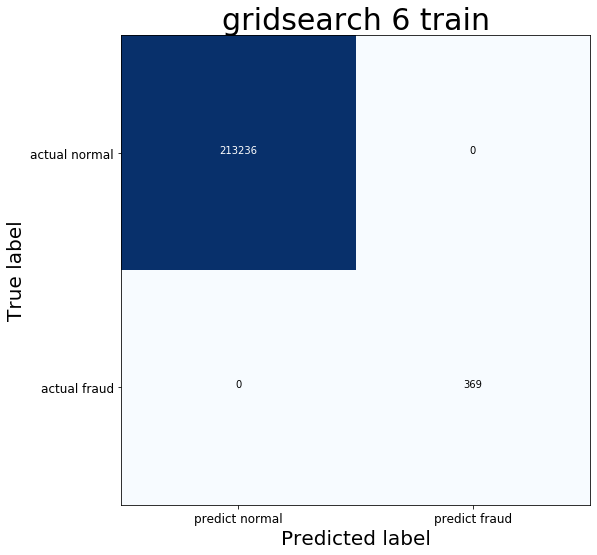

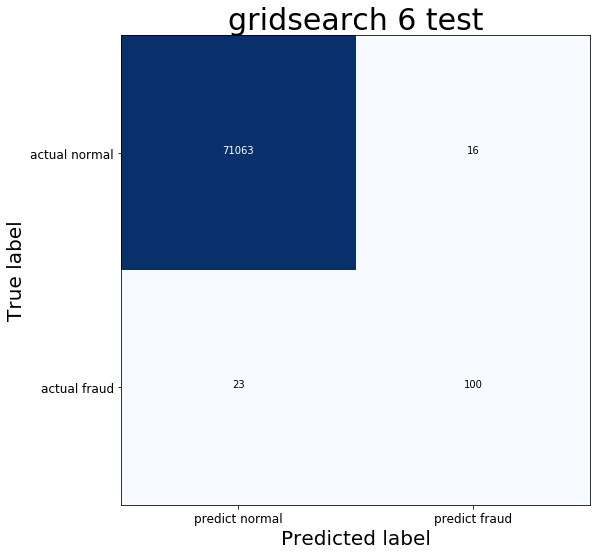

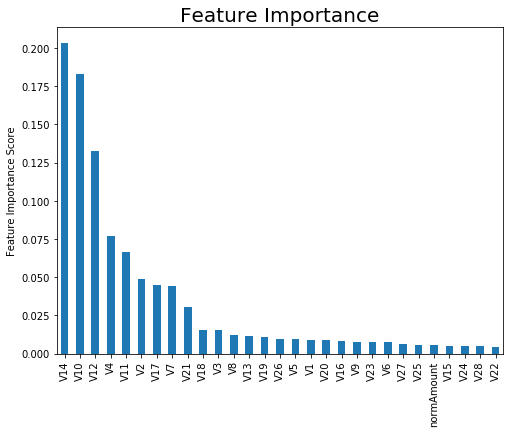

In [52]:
# max_features = log2
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=22, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'log2',
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=20, 
                                            subsample=1, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

model_vis(model,'gridsearch 6')